In [6]:

from itertools import product
import sys
from PIL import Image
from os import listdir

import numpy as np
import torch
import torchvision
from torchvision import transforms

from lucent.modelzoo import *
from lucent.misc.io import show
import lucent.optvis.objectives as objectives
import lucent.optvis.param as param
import lucent.optvis.render as render
import lucent.optvis.transform as transform
from lucent.misc.channel_reducer import ChannelReducer
from lucent.misc.io import show

In [10]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()

Using cache found in /Users/sturla/.cache/torch/hub/pytorch_vision_v0.10.0


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [260]:
def transform_image(input_image):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    return input_batch

def predict_category(output, j):
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    #print(output[j])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[j], dim=0)
    #print(probabilities)
    # Read the categories
    with open("data/categories.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())

def predict_image(input_batch):
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    
    with torch.no_grad():
        output = model(input_batch)
        
    for j in range(output.shape[0]):
        predict_category(output, j)
        print("\n")
    

In [261]:

input_image = Image.open("data/ILSVRC2015/Data/DET/test/ILSVRC2012_test_00002514.JPEG")
input_batch = transform_image(input_image)
predict_image(input_batch)

277: 'red fox, Vulpes vulpes', 0.6867847442626953
278: 'kit fox, Vulpes macrotis', 0.2572617530822754
280: 'grey fox, gray fox, Urocyon cinereoargenteus', 0.03158718720078468
274: 'dhole, Cuon alpinus', 0.011068567633628845
272: 'coyote, prairie wolf, brush wolf, Canis latrans', 0.0017953580245375633




In [270]:
@torch.no_grad()
def get_layer(model, layer, X):
    hook = render.ModuleHook(getattr(model, layer))
    model(X)
    hook.close()
    return hook.features


In [271]:
print(get_layer(model, "inception4a", input_batch)[0][456].mean())

tensor(0.3301)


In [272]:
all_layers = ["conv1", "maxpool1", "conv2", "conv3", "maxpool2", "inception3a", "inception3b","maxpool3", "inception4a", "inception4b", "inception4c", "inception4d", "inception4e", "maxpool4", "inception5a", "inception5b", "avgpool", "dropout", "fc"]
layers = ["inception3a", "inception3b","inception4a", "inception4b", "inception4c", "inception4d", "inception4e", "inception5a", "inception5b"]
#fewer_layers = ["inception3a", "inception3b","inception4a", "inception4b", "inception4c", "inception4d", "inception4e", "inception5a", "inception5b"]

In [296]:
def get_all_layers(model, layers,X):
    hooks = [render.ModuleHook(getattr(model, layer)) for layer in layers]
    model(X)
    for hook in hooks:
        hook.close()
    return [hook.features for hook in hooks]



In [297]:
def get_activations(model, layers, num, path = "data/ILSVRC2015/Data/DET/test/"):
    images = [ ]
    for file in listdir(path)[:num]:
        images.append(transform_image(Image.open(path+file)))
    images = torch.cat(images)
    #images = transform_image(images)
    activations = get_all_layers(model, layers, images)
    #activations = [act.mean(dim=[2,3]) for act in activations]
    activations = [act.max(dim=3)[0].max(dim=2)[0] for act in activations]
    torch.save(biggg, "activations/max_activations.pt")
#predict_image(images)


In [298]:
get_activations(model, layers, 101)

In [206]:
biggg= get_all_layers(model, layers, images)

In [207]:
for big in biggg:
    print(big.shape)

torch.Size([10, 256, 28, 28])
torch.Size([10, 480, 28, 28])
torch.Size([10, 512, 14, 14])
torch.Size([10, 512, 14, 14])
torch.Size([10, 512, 14, 14])
torch.Size([10, 528, 14, 14])
torch.Size([10, 832, 14, 14])
torch.Size([10, 832, 7, 7])
torch.Size([10, 1024, 7, 7])


In [122]:
biggg = [big.mean(dim=[2,3]) for big in biggg]

In [208]:
biggg = [big.max(dim=3)[0].max(dim=2)[0] for big in biggg]

In [126]:
print(biggg[4][0][0])

tensor([[2.2027, 2.1742, 2.2797,  ..., 2.4165, 2.2177, 1.8543],
        [0.3978, 2.0528, 1.9185,  ..., 1.1010, 1.1627, 0.9440],
        [2.6084, 6.2795, 4.0731,  ..., 2.3150, 3.3103, 3.1855],
        ...,
        [0.1734, 0.2061, 0.0593,  ..., 0.4217, 0.1555, 0.2065],
        [0.5509, 0.3246, 0.0000,  ..., 0.3174, 0.3212, 0.4643],
        [0.1667, 0.0000, 0.0000,  ..., 1.1627, 1.1597, 0.9020]],
       grad_fn=<SelectBackward0>)


In [210]:
torch.save(biggg, "data/max_activations.pt")

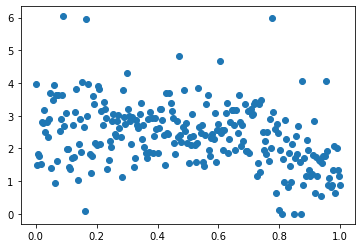

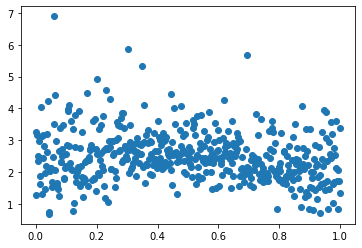

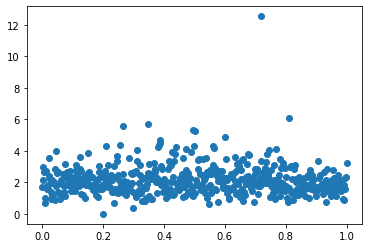

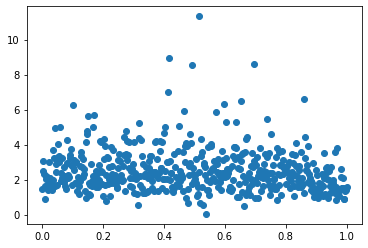

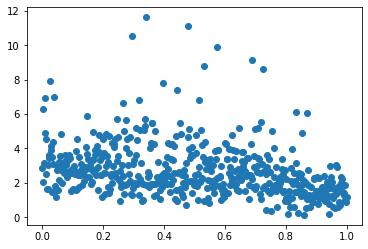

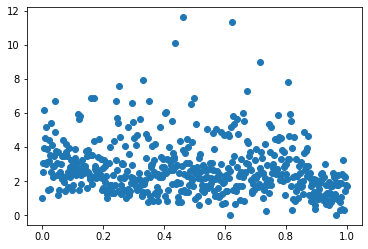

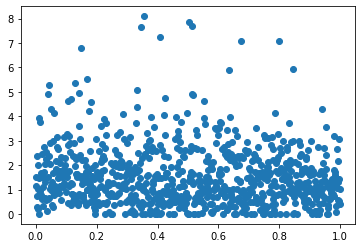

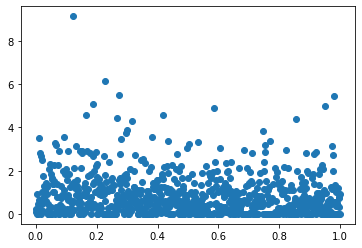

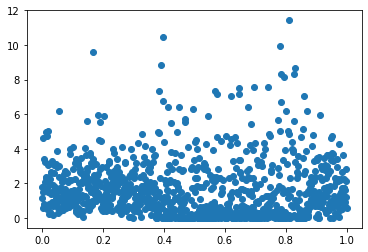

In [135]:
import matplotlib.pyplot as plt
for big in biggg:
    plt.figure()
    plt.scatter(x=np.linspace(0,1,len(big[0])),y=big[0].detach().numpy())
plt.show()

In [15]:
data = torch.load("activations/mean_activations_test.pt")
print([tens.shape for tens in data])

[torch.Size([543, 256]), torch.Size([543, 480]), torch.Size([543, 512]), torch.Size([543, 512]), torch.Size([543, 512]), torch.Size([543, 528]), torch.Size([543, 832]), torch.Size([543, 832]), torch.Size([543, 1024])]
